# Masalah di Interpolasi Polinomial

Misalkan diberikan 21 pasang titik $(x_k,y_k)$ dimana $k=0,1,...,20$. Tujuannya adalah mencari suatu fungsi yang melalui titik-titik tersebut.

Pertama, kita gunakan interpolasi Lagrange: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy import interpolate

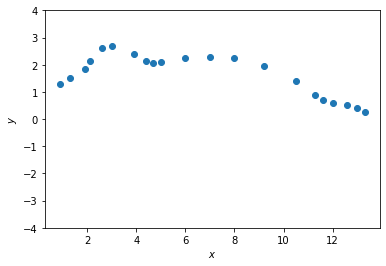

In [3]:
x = np.array([0.9, 1.3, 1.9, 2.1, 2.6, 3.0, 3.9, 4.4, 4.7, 5.0, 6.0, 7.0, 8.0, 9.2, 10.5, 11.3, 11.6, 12.0, 12.6, 13.0, 13.3])
y = np.array([1.3, 1.5, 1.85, 2.12, 2.6, 2.7, 2.4, 2.15, 2.05, 2.11, 2.25, 2.3, 2.26, 1.95, 1.4, 0.9, 0.7, 0.6, 0.5, 0.4, 0.25])

plt.scatter(x,y);
plt.xlabel("$x$");
plt.ylabel("$y$");
plt.ylim([-4, 4]);

Karena terdapat 21 titik data, maka interpolan Lagrange membutuhkan polinom berderajat 20.

In [4]:
f = interpolate.lagrange(x,y) # 20 derajat polinomial

In [5]:
f

poly1d([-3.54868435e-11,  4.94299642e-09, -3.20527566e-07,  1.28512185e-05,
       -3.56883654e-04,  7.28781256e-03, -1.13401396e-01,  1.37498064e+00,
       -1.31748437e+01,  1.00596514e+02, -6.14483947e+02,  3.00331353e+03,
       -1.17053352e+04,  3.61211679e+04, -8.72406759e+04,  1.62083353e+05,
       -2.25783901e+05,  2.26808970e+05, -1.54212429e+05,  6.31122777e+04,
       -1.16552715e+04])

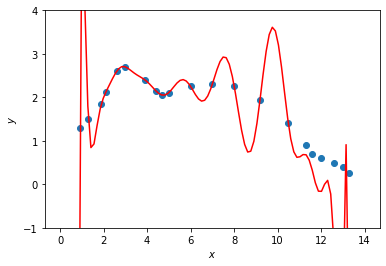

In [6]:
xi = np.linspace(0, 14, 100)
plt.plot(xi, f(xi), 'r')
plt.scatter(x,y)
plt.xlabel("$x$");
plt.ylabel("$y$");
plt.ylim([-1, 4]);

Dari grafik di atas terlihat bahwa interpolan Lagrange menghasilkan error yang besar. Hal ini terjadi karena penggunaan polinom berderajat tinggi yang diakibatkan dari banyaknya titik data yang digunakan. Ini berarti semakin tinggi derajat polinom yang digunakan, maka error yang dihasilkan akan semakin besar. Fenomena ini disebut juga dengan _Runge Phenomenon_.

# Interpolasi Piece-Wise

Untuk menangani masalah penggunaan polinom berderajat tinggi dari suatu interpolan, maka caranya adalah dengan membagi interval dari titik data ke dalam sub-sub interval.

### Contoh 1:
Diberikan titik (1,2), (2,3), dan (3,5)

In [7]:
x = np.array([1,2,3])
y = np.array([2,3,5])

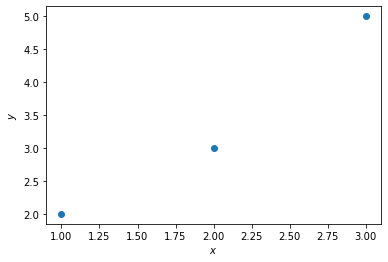

In [8]:
plt.scatter(x,y);
plt.xlabel("$x$");
plt.ylabel("$y$");

In [9]:
S0 = lambda x: 2 + 0.75*(x-1) + 0.25*(x-1)**3
S1 = lambda x: 3 + (3/2)*(x-2) + 0.75*(x-2)**2 - (0.25)*(x-2)**4

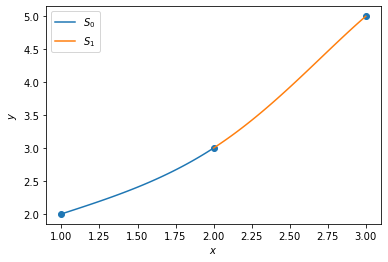

In [10]:
xi1 = np.linspace(1, 2, 100)
xi2 = np.linspace(2, 3, 100)
plt.plot(xi1, S0(xi1), label='$S_0$')
plt.plot(xi2, S1(xi2), label='$S_1$')
plt.scatter(x,y);
plt.xlabel("$x$");
plt.ylabel("$y$");
plt.legend();

### Implementasi Cubic Spline (Natural Boundary)

Panggil fungsi `gauss_seidel` untuk menyelesaikan sistem persamaan linear yang dihasilkan dari bentuk matriks cubic spline.

In [11]:
def gauss_seidel(A, b, x0, epsilon=1e-5, N=1000):
  x = np.zeros_like(b, dtype=np.double)
  
  for k in range(N):

    for i in range(len(b)):
      U = np.dot(A[i,:i], x[:i])
      V = np.dot(A[i,(i+1):], x0[(i+1):])
      x[i] = 1/A[i,i] * (b[i] - U - V)
      #print(k,x)
      
    if np.linalg.norm(np.dot(A,x) - b) < epsilon:
      break
    
    x0 = x

  return x

Implementasikan code dibawah ini untuk mencari nilai $a,b,c,d$ dari persamaan cubic spline

In [12]:
def cubic_spline(data):
  n = len(data) - 1

  data = np.array(data)

  # Nilai dari koef. a diketahui dari titik data atau input yaitu a_j = f(x_j)
  a = [data[i, 1] for i in range(n+1)]
  a = np.array(a)

  h = [(data[i+1,0] - data[i,0]) for i in range(n)]
  
  # Membentuk matriks A
  A = np.zeros((n+1,n+1))
  for i in range(1, n):
    for j in range(0, n):
      if j < i:
        for k in range(j):
          A[i,k] = 0
        A[i,j] = h[j-1]
      elif j > i:
        for k in range(j):
          A[k,j] = 0
        A[i,j] = h[j]
        A[i+1, j+1] = h[j]
      else:
        A[i,i] = 2*(h[j-1] + h[j])
  A[0, 0] = 1
  A[n, n] = 1
  A[:n-1, n] = 0

  # Membentuk vektor b
  b = np.zeros(n+1)
  for i in range(1,n):
    b[i] = (3/h[i]) * (a[i+1] - a[i]) - (3/h[i-1]) * (a[i] - a[i-1])

  # Cari nilai koef. c dengan Gauss-Seidel
  x0 = np.zeros(n+1)
  c = gauss_seidel(A, b, x0)

  # Mencari koef. b dan d setelah koef. c didapatkan
  d = np.zeros(n+1)
  for i in range(n):
    b[i] = (a[i+1] - a[i])/h[i] - h[i]*(c[i+1] + 2*c[i])/3
    d[i] = (c[i+1] - c[i])/3*h[i]

  return a, b, c, d

### Contoh 2: 
Diberikan titik data $(0,1), (1,e), (2, e^2), (3, e^3)$

In [13]:
X = [(0,1), (1,np.exp(1)), (2,(np.exp(1))**2), (3,(np.exp(1))**3)]
X = np.array(X)
X

array([[ 0.        ,  1.        ],
       [ 1.        ,  2.71828183],
       [ 2.        ,  7.3890561 ],
       [ 3.        , 20.08553692]])

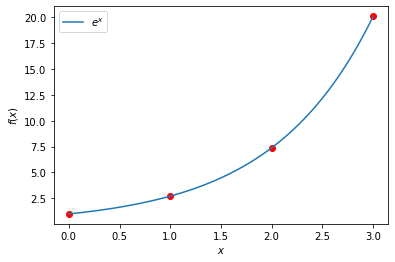

In [14]:
xi = np.linspace(0, 3, 100)
plt.scatter(X[:,0], X[:,1], c='red')
plt.plot(xi, np.exp(xi), label='$e^x$')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend();

In [15]:
import pprint
pp = pprint.PrettyPrinter(indent=2, compact=True)
# Cari koef. untuk S
a,b,c,d = cubic_spline(X)

P = [a,b,c,d]
pp.pprint(P)

[ array([ 1.        ,  2.71828183,  7.3890561 , 20.08553692]),
  array([1.46599715, 2.22284945, 8.80976989, 0.        ]),
  array([0.        , 0.75685403, 5.83006641, 0.        ]),
  array([ 0.25228468,  1.69107079, -1.94335547,  0.        ])]


In [16]:
S0 = lambda x: a[0] + b[0]*x + d[0]*(x**3)
S1 = lambda x: a[1] + b[1]*(x - 1) + c[1]*((x - 1)**2) + d[1]*((x-1)**3)
S2 = lambda x: a[2] + b[2]*(x - 2) + c[2]*((x - 2)**2) + d[2]*((x-2)**3)

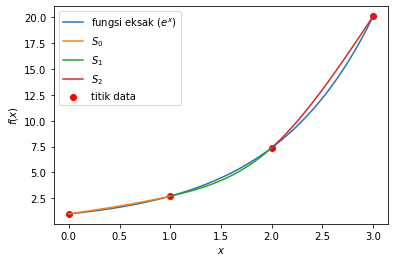

In [17]:
interval = [np.linspace(i, i+1, 100) for i in range(len(X)-1)]
plt.scatter(X[:,0], X[:,1], c='red', label='titik data')
plt.plot(xi, np.exp(xi), label='fungsi eksak ($e^x$)')
plt.plot(interval[0], S0(interval[0]), label='$S_0$')
plt.plot(interval[1], S1(interval[1]), label='$S_1$')
plt.plot(interval[2], S2(interval[2]), label='$S_2$')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend();

#### Contoh 3:

Kita juga dapat menghitung integral untuk $f(x)=e^x$ di $[0,3]$ menggunakan cubic spline:



In [18]:
S_integral = (a[0]+a[1]+a[2]) + 0.5*(b[0]+b[1]+b[2]) + 1/3*(c[0]+c[1]+c[2]) + 1/4*(d[0]+d[1]+d[2])
S_integral

19.5522863156542

In [19]:
import scipy.integrate as integral

f = lambda x: np.exp(x)
f_integral = integral.quad(f, 0, 3)
f_integral

(19.085536923187668, 2.1189202529456516e-13)

In [20]:
error = np.abs(S_integral - f_integral[0])/np.abs(f_integral[0])
error

0.02445565950515453

Adakah metode yang dapat menghasilkan error yg lebih kecil? cubic spline dengan clamped boundary 

### Contoh 4:

In [21]:
x = np.array([0.9, 1.3, 1.9, 2.1, 2.6, 3.0, 3.9, 4.4, 4.7, 5.0, 6.0, 7.0, 8.0, 9.2, 10.5, 11.3, 11.6, 12.0, 12.6, 13.0, 13.3])
y = np.array([1.3, 1.5, 1.85, 2.12, 2.6, 2.7, 2.4, 2.15, 2.05, 2.11, 2.25, 2.3, 2.26, 1.95, 1.4, 0.9, 0.7, 0.6, 0.5, 0.4, 0.25])

data = [list(a) for a in zip(x, y)]
data = np.array(data)

In [22]:
len(data)

21

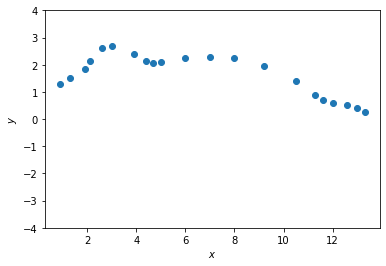

In [23]:
plt.scatter(data[:,0], data[:,1]);
plt.xlabel("$x$");
plt.ylabel("$y$");
plt.ylim([-4, 4]);

In [24]:
# Cari koef. untuk S
a,b,c,d = cubic_spline(data)

P = [a,b,c,d]
pp.pprint(P)

[ array([1.3 , 1.5 , 1.85, 2.12, 2.6 , 2.7 , 2.4 , 2.15, 2.05, 2.11, 2.25,
       2.3 , 2.26, 1.95, 1.4 , 0.9 , 0.7 , 0.6 , 0.5 , 0.4 , 0.25]),
  array([ 0.50867103,  0.22927812,  1.19189293,  1.56531556,  0.5232126 ,
        0.00299365, -0.47774079, -0.5013043 , -0.07292301,  0.30322867,
        0.08678753,  0.01441943, -0.1334637 , -0.32538813, -0.51773512,
       -0.73247255, -0.51355467, -0.15157408, -0.16927086, -0.39666192,
        0.        ]),
  array([ 0.        , -0.06503275,  1.90034154, -1.4290771 , -0.77373917,
       -0.50161617, -0.1178576 ,  0.10215994,  1.4753898 , -0.2215495 ,
       -0.04658699, -0.01718862, -0.12888106, -0.05441196, -0.11661175,
       -0.16901982,  0.99609847, -0.01553695, -0.04438905, -0.51669041,
        0.        ]),
  array([-0.00867103,  0.39307486, -0.22196124,  0.10922299,  0.03628307,
        0.11512757,  0.03666959,  0.13732299, -0.16969393,  0.05832084,
        0.00979946, -0.03723081,  0.02978764, -0.02695324, -0.01397548,
        0.1165

In [25]:
n = len(data)
S = [(lambda x, j = j: a[j] + b[j]*(x - data[j,0]) + c[j]*((x - data[j,0])**2) + d[j]*((x - data[j,0])**3)) for j in range(n-1)]

In [26]:
len(S)

20

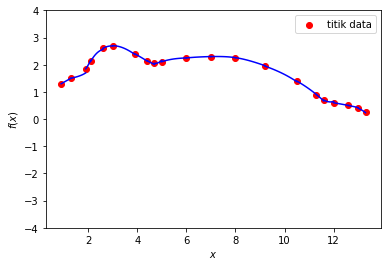

In [27]:
interval = [np.linspace(data[i,0], data[i+1, 0], 100) for i in range(n-1)]
plt.scatter(data[:,0], data[:,1], c='red', label='titik data')
for i in range(0, n-1):
  plt.plot(interval[i], S[i](interval[i]), 'b')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim([-4, 4]);
plt.legend();